# Augmented Reality with Planar Homographies

In [3]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

In [2]:
def loadVid(path):
	# Create a VideoCapture object and read from input file
	# If the input is the camera, pass 0 instead of the video file name
	cap = cv2.VideoCapture(path)
	 
	# Check if camera opened successfully
	if (cap.isOpened()== False): 
		print("Error opening video stream or file")

	i = 0
	# Read until video is completed
	while(cap.isOpened()):
		# Capture frame-by-frame
		i += 1
		ret, frame = cap.read()
		if ret == True:

			#Store the resulting frame
			if i == 1:
				frames = frame[np.newaxis, ...]
			else:
				frame = frame[np.newaxis, ...]
				frames = np.vstack([frames, frame])
				frames = np.squeeze(frames)
			
		else: 
			break
	 
	# When everything done, release the video capture object
	cap.release()

	return frames


## Getting Correspondences

In [146]:
def find_correspondences(img1,img2):
    img11 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    img22 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
                        
    sift = cv2.SIFT_create()
    # get keypoints and descriptors in each img
    kp1, des1 = sift.detectAndCompute(img11,None)
    kp2, des2 = sift.detectAndCompute(img22,None)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
 
    good = []
    for m,n in matches:
        if m.distance/n.distance < 0.65:
            # m contains queryIdx, trainIdx which correspond to the indices of the matched keypoint1,keypoint2 in their respective lists
            good.append([m])
            #print(m.queryIdx)
            #print(m.trainIdx)
            
    for i in range(len(good)):
        good[i] = sorted(good[i], key = lambda x:x.distance)
        
    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good[:50],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15,10)), plt.imshow(img3),plt.show()
    
    img1_pts = np.float32([kp1[m.queryIdx].pt for [m] in good]).reshape(-1,1,2)
    img2_pts = np.float32([kp2[m.trainIdx].pt for [m] in good]).reshape(-1,1,2)
    
    # print(img1_pts)
    
    correspondences = [(tuple(pt1[0]), tuple(pt2[0])) for pt1, pt2 in zip(img1_pts, img2_pts)]
    
    return img1_pts,img2_pts, correspondences
    
    

In [15]:
img1 = cv2.imread('cv_cover.jpg')
frames = loadVid('book.mov')


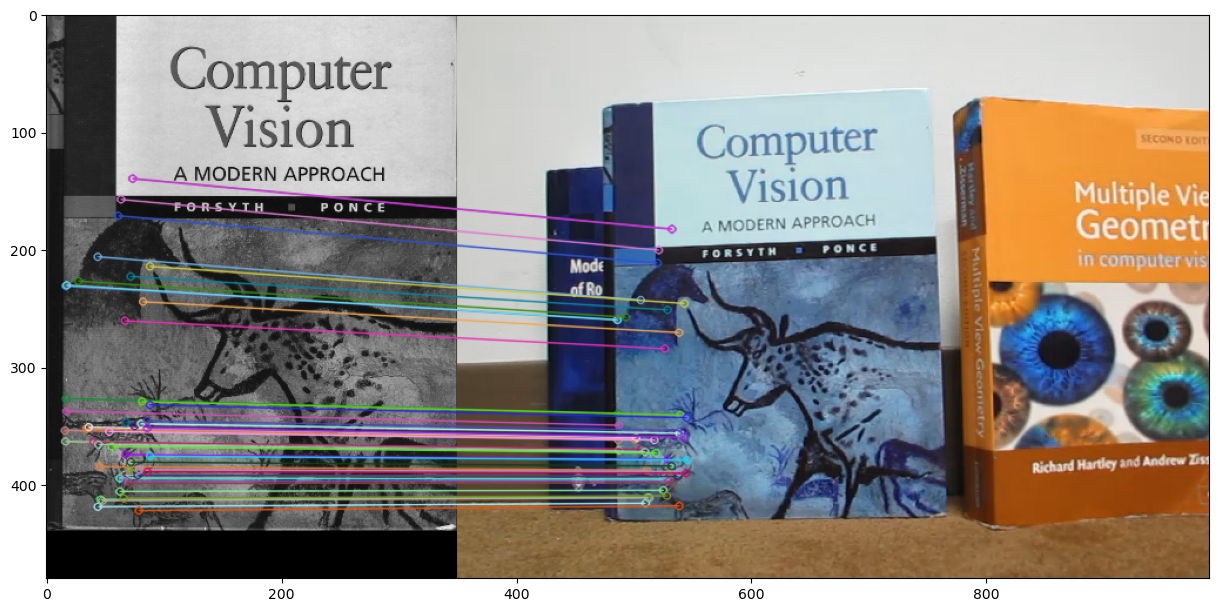

In [142]:
img1_pts,img2_pts,corr = find_correspondences(img1,frames[0])

## Compute the Homography Parameters

In [127]:
def compute_homography(correspondences):
    assert len(correspondences)>=4
    A = [] # 2n x 8
    b = [] # 2n x 1
    
    for ((x1,y1),(x2,y2)) in correspondences:
        A.append([x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2])
        A.append([0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2])
        b.append(x2), b.append(y2)
    
    H = np.linalg.lstsq(np.array(A),np.array(b),rcond=None)[0] # 8 x 1
        
    return np.append(H,1).reshape((3,3))


In [128]:
def compute_homography_ransac(img1_pts,img2_pts):
    # ransacReprojThreshold:    Maximum allowed reprojection error to treat a point pair as an inlier (set to 3.0 here)
    H, _ = cv2.findHomography(np.array(img1_pts), np.array(img2_pts), cv2.RANSAC, ransacReprojThreshold=3.0)
    return H

In [138]:
def verify_homography(img1,img2,H,correspondences):
    img1_pts = []
    img2_pts = []
    
    for ((x1,y1),(x2,y2)) in correspondences:
        pt1_homogenous = np.array([x1,y1,1])
        pt2_homogenous = np.array([x2,y2,1])
        pt1_transformed = np.matmul(H,pt1_homogenous)
        pt2_transformed = np.matmul(np.linalg.inv(H),pt2_homogenous)
        pt1_transformed_cart = (pt1_transformed[0]/pt1_transformed[2],pt1_transformed[1]/pt1_transformed[2])
        pt2_transformed_cart = (pt2_transformed[0]/pt2_transformed[2],pt2_transformed[1]/pt2_transformed[2])
        
        img1_pts.append([(x1,y1),pt2_transformed_cart])
        img2_pts.append([(x2,y2),pt1_transformed_cart])
        
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img1)
    axs[0].set_title("Image 1")
    for [(x1,y1),pt2_transformed_cart] in img1_pts:
        axs[0].plot(x1, y1, 'wo', markersize=3)  # Original point
        axs[0].plot(pt2_transformed_cart[0], pt2_transformed_cart[1], 'ro', markersize=2)  # Transformed point
        
    axs[1].imshow(img2)
    axs[1].set_title("Image 2")
    for [(x2,y2),pt1_transformed_cart] in img2_pts:
        axs[1].plot(x2, y2, 'wo', markersize=3)  # Original point
        axs[1].plot(pt1_transformed_cart[0], pt1_transformed_cart[1], 'ro', markersize=2)  # Transformed point
    
    plt.show()
        
        

In [143]:
H = compute_homography(corr)
H

array([[ 6.86074396e-01, -1.50175110e-02,  1.26903785e+02],
       [-1.04503935e-01,  7.26483086e-01,  8.72061430e+01],
       [-2.54501267e-04, -1.35207431e-04,  1.00000000e+00]])

In [144]:
H2 = compute_homography_ransac(img1_pts,img2_pts)
H2

array([[ 7.83468337e-01,  7.34081727e-03,  1.18320715e+02],
       [-4.75627581e-02,  7.87709823e-01,  7.63430829e+01],
       [-7.81422506e-05, -5.98336590e-05,  1.00000000e+00]])

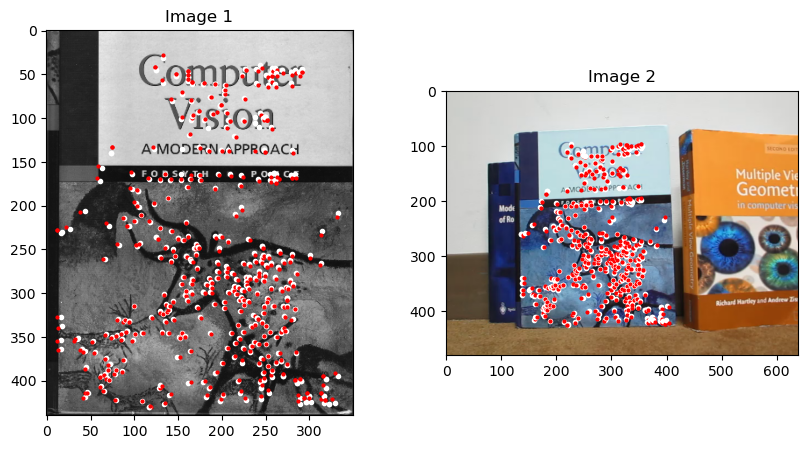

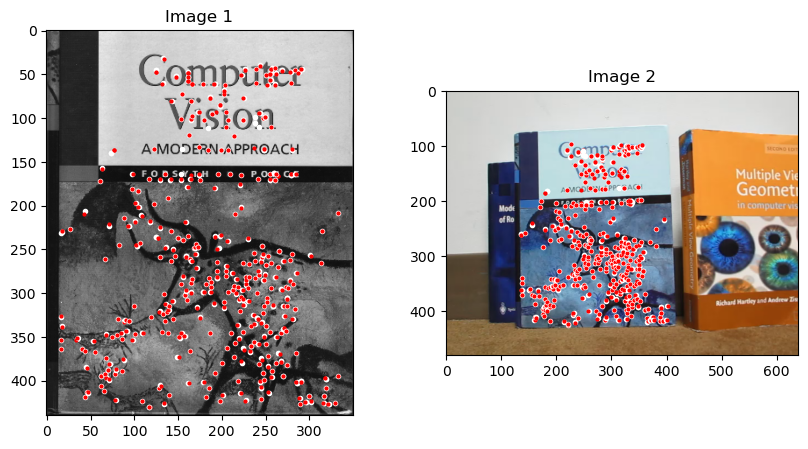

In [145]:
verify_homography(img1,frames[0],H,corr)
verify_homography(img1,frames[0],H2,corr)